In [1]:
import os
import sys
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

%load_ext autoreload
%autoreload 1

from tools.calc_antarctic_mass_loss import calc_antarctic_mass_loss
from visualization.plot_avg_ismr_map import plot_avg_ismr_diff_map

%aimport tools.calc_antarctic_mass_loss,visualization.plot_avg_ismr_map

In [20]:
def plot_ismr_temp_map(m_from,m_to,temp_from,temp_to,grd,title_str,m_min=-1,m_max=1,t_min=-1,t_max=1,tp_min=-100,tp_max=100,mp_min=-500,mp_max=500,out_path=None):

    s2a = 3600*24*365.25
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)
    
    m_diff = (m_to-m_from)*s2a
    m_diff_rel = (m_to-m_from)/xr.ufuncs.fabs(m_from)*100
    
    temp_diff = (temp_to-temp_from)
    temp_diff_rel = (temp_to-temp_from)/xr.ufuncs.fabs(temp_from)*100
    
    plt.close()
    fig,axes = plt.subplots(ncols=2,figsize=(25,8))
    ax1,ax2 = axes.flatten()
    for ax in axes:
        ax.contourf(grd.mask_rho.where(land_zice).values,colors=(('0.6','0.6','0.6')))
        ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.set_aspect('equal')
        ax.axis('off')

    (m_diff.where(mask))[1:-1,1:-1].plot(vmin=m_min,vmax=m_max,ax=ax1,cmap=plt.cm.seismic,cbar_kwargs={'label':'melt rate difference in m/yr'})
    temp_diff.where(~land_zice)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax1,cmap=ocm.balance,cbar_kwargs={'label':'temperature difference in degC'})
    ax1.set_title('Difference in melt rate (m/yr) and\n bottom layer temperature  (degC)',fontsize=20)
    (m_diff_rel.where(mask))[1:-1,1:-1].plot(vmin=mp_min,vmax=mp_max,ax=ax2,cmap=plt.cm.seismic,cbar_kwargs={'label':'melt rate relative difference in %'})
    temp_diff_rel.where(~land_zice)[1:-1,1:-1].plot(vmin=tp_min,vmax=tp_max,ax=ax2,cmap=ocm.balance,cbar_kwargs={'label':'temperature relative difference in %'})
    ax2.set_title('Relative difference in melt rate and\n bottom layer temperature (%)',fontsize=20)
    
    
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,dpi=300)
    plt.show()

In [3]:
file_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0009.nc')
tides4 = xr.open_dataset(file_path)

file_path = os.path.join(data_dir,'raw','waom4_nt','ocean_avg_0009.nc')
no_tides4 = xr.open_dataset(file_path)

grid_path = os.path.join(proj_dir,'data','preprocessing','processed','waom4_grd.nc')
grd4 = xr.open_dataset(grid_path)

out_path = os.path.join(proj_dir,'reports','figures','tidal_melting.png')

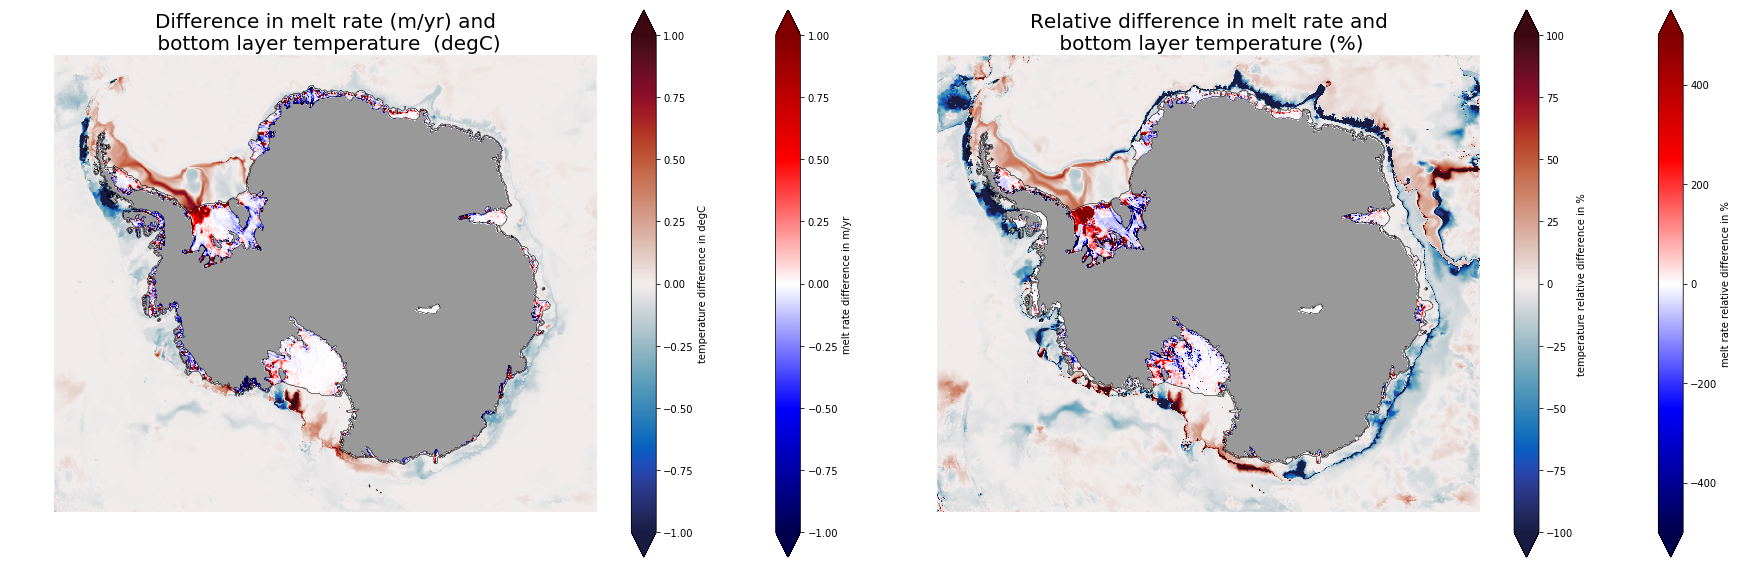

In [21]:
%matplotlib inline
plot_ismr_temp_map(no_tides4.m.mean('ocean_time'),tides4.m.mean('ocean_time'),
                   no_tides4.temp.isel(s_rho=0).mean('ocean_time'),tides4.temp.isel(s_rho=0).mean('ocean_time'),
                   grd4,'test',out_path=out_path)

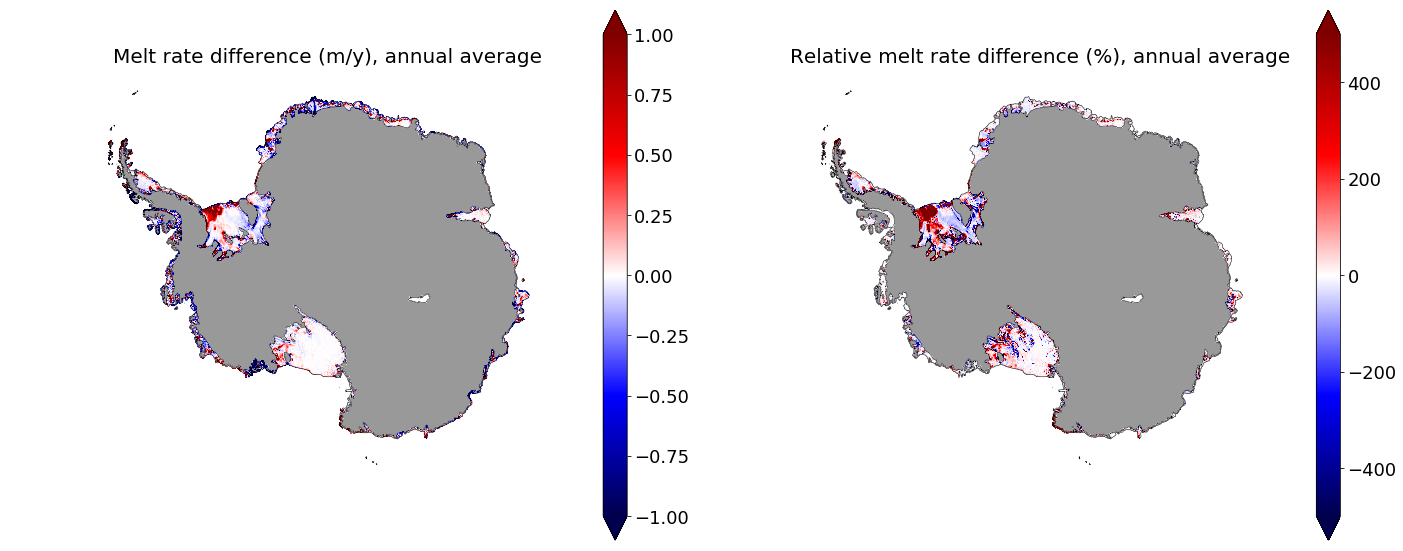

In [4]:
%matplotlib inline   
plot_avg_ismr_diff_map(no_tides4.m,tides4.m,grd4,p_min=-500,p_max=500,out_path=out_path)

In [6]:
calc_antarctic_mass_loss(tides4.m-no_tides4.m,grd4)

Area of all ice shelves in 10^3 km^2:  1690.8425444117381
Area average melt rate in m/yr:  0.036581509362304525
Basal mass loss in Gt/a:  56.657872289621054
